# Installing and importing packages

In [ ]:
!pip3 install pycodestyle
!pip3 install --index-url https://test.pypi.org/simple/ nbpep8

Looking in indexes: https://test.pypi.org/simple/


In [ ]:
from nbpep8.nbpep8 import pep8

In [ ]:
!pip install transformers
!pip install rusenttokenize

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from bs4 import BeautifulSoup
import nltk
from rusenttokenize import ru_sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
import transformers
from transformers import AdamW
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.utils.data import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preparation

In [ ]:
WORK_DIR_FOR_TRAIN = "/content/drive/My Drive/RSTreebank/train"
WORK_DIR_FOR_TEST = "/content/drive/My Drive/RSTreebank/test"

In [ ]:
def relation_detection_preprocessing(file_path):
    """Parses and preprocesses data for the Relation Semantics Detection task."""
    segments, groups = [], []
    for filename in os.listdir(file_path):
        with open(os.path.join(file_path, filename), 'r') as f:
            text = f.read()
            soup = BeautifulSoup(text, 'html.parser')
            groups.append(soup.findAll('group'))
            segments.append(soup.findAll('segment'))
    relnames, text_pieces = [], []
    disc_dict = {}
    for i, text in enumerate(segments):
        full_text = []
        for sg in text:
            full_text.append(sg.text)
        disc_unit = ru_sent_tokenize(' '.join(full_text))
        disc_dict[i] = disc_unit
    for i, text in enumerate(segments):
        for sg in text:
            if 'parent' in str(sg):
                try:
                    relnames.append(sg['relname'])
                    corresponding_passage = [
                        elem for elem in disc_dict[i] if sg.text in elem+'.'
                        ][0]
                    prompt = sg.text.strip('#') + ' => ' + corresponding_passage
                    text_pieces.append(prompt)
                except:
                    relnames.pop()
                    pass
    df = pd.DataFrame({'text': text_pieces, 'label': relnames})
    return df


In [ ]:
def swapped_sentence_preprocessing(file_path, train_mode=True):
    """Parsing and processes data for the Swapped Sentence Units Detection task,
    which includes searching discource units, shuffling them, and creating new
    pseudo-sentences."""
    segments, groups = [], []
    for filename in os.listdir(file_path):
        with open(os.path.join(file_path, filename), 'r') as f:
            text = f.read()
            soup = BeautifulSoup(text, 'html.parser')
            groups.append(soup.findAll('group'))
            segments.append(soup.findAll('segment'))
    relnames, text_pieces = [], []
    disc_dict = {}
    for i, text in enumerate(segments):
        full_text = []
        for sg in text:
            full_text.append(sg.text)
        disc_unit = ru_sent_tokenize(' '.join(full_text))
        for sentence in disc_unit:
            sent_tokens = [elem for elem in full_text if elem in sentence]
            if len(sent_tokens) > 1:
                text_pieces.append(sent_tokens)
    random.shuffle(text_pieces)
    if train_mode==True:
        for i in range(646):
            random.shuffle(text_pieces[i])
            relnames.append(0)
        for i in range(646, 1294):
            relnames.append(1)
        df = pd.DataFrame({'text': text_pieces, 'label': relnames})
    else:
        for i in range(97):
            random.shuffle(text_pieces[i])
            relnames.append(0)
        for i in range(97, 193):
            relnames.append(1)
        df = pd.DataFrame({'text': text_pieces, 'label': relnames})
    return df



In [ ]:
def scrambled_sentence_preprocessing(file_path, train_mode=True):
    """Parsing and processes data for the Scrambled Sentence Detection task,
    which includes swapping two parts of a sentence, making it incoherent."""
    segments, groups = [], []
    for filename in os.listdir(file_path):
        with open(os.path.join(file_path, filename), 'r') as f:
            text = f.read()
            soup = BeautifulSoup(text, 'html.parser')
            groups.append(soup.findAll('group'))
            segments.append(soup.findAll('segment'))
    relnames, text_pieces = [], []
    disc_dict = {}
    for i, text in enumerate(segments):
        full_text = []
        for sg in text:
            full_text.append(sg.text)
        disc_unit = ru_sent_tokenize(' '.join(full_text))
        for sentence in disc_unit:
            sent_tokens = [elem for elem in full_text if elem in sentence]
            if len(sent_tokens) > 1:
                text_pieces.append(sent_tokens)
    random.shuffle(text_pieces)
    if train_mode == True:
        for i in range(0, 646, 2):
            text_pieces[i][1], text_pieces[i+1][1] = text_pieces[i+1][1], text_pieces[i][1]
            relnames.append(0)
            relnames.append(0)
        for i in range(646, 1294):
            relnames.append(1)
    else:
          for i in range(0, 97, 2):
              text_pieces[i][1], text_pieces[i+1][1] = text_pieces[i+1][1], text_pieces[i][1]
              relnames.append(0)
              relnames.append(0)
          for i in range(98, 193):
            relnames.append(1)
    df = pd.DataFrame({'text': text_pieces, 'label': relnames})
    return df



In [ ]:
class DiscourseDataset(Dataset):
    """A general dataset class which prepares preproccessed data for training."""
    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          truncation=True,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
        )

        #assert len(encoding['input_ids'])==self.max_len

        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }



In [ ]:
def create_data_loader(dataset, tokenizer, max_len=140, batch_size=16, shuffle=True):
    """Creates a DiscourseDataset instance and makes a Dataloader out of it. """
    ds = DiscourseDataset(
        text=dataset.text.to_numpy(),
        targets=dataset.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4,
        shuffle=shuffle
    )



# Model

In [ ]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased", return_dict=False)
model = BertModel.from_pretrained("DeepPavlov/rubert-base-cased", return_dict=False)
device = torch.device('cuda')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class DiscourseClassifier(nn.Module):
    """Creates a multiclass classifier by adding a Dropout layer for
    regularization and a fully connected layer for classification"""
    def __init__(self, n_classes):
        super(DiscourseClassifier, self).__init__()
        self.bert = model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

# Training and Evaluation

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def trainer(model, epochs):
    history = defaultdict(list)
    best_accuracy = 0
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
          model,
          train_data_loader,
          loss_fn,
          optimizer,
          device,
          scheduler,
          len(sampled_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')
        '''
        val_acc, val_loss = eval_model(
          rubert,
          val_data_loader,
          loss_fn,
          device,
          len(df_val)
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()
        '''
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        #history['val_acc'].append(val_acc)
        #history['val_loss'].append(val_loss)

        if train_acc > best_accuracy:
          torch.save(model.state_dict(), 'best_model_state.bin')
          best_accuracy = train_acc

In [ ]:
def evaluator(model):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in test_data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

# Experiment 1. Swapped Sentence Units

In [ ]:
train = swapped_sentence_preprocessing(WORK_DIR_FOR_TRAIN)
test = swapped_sentence_preprocessing(WORK_DIR_FOR_TEST, train_mode=False)

In [ ]:
train['text'] = train['text'].apply(lambda x: ' '.join(x))
test['text'] = test['text'].apply(lambda x: ' '.join(x))

In [ ]:
for sent in train['text'][:5]:
    print(sent)

как по всей стране прошла минута молчания в память о жертвах этого преступления. Обама выступал в Белом доме через несколько часов после того,
и относится к так называемому «провинциальному» типу. Пирамида находится неподалеку от древнего поселения Эдфу (около ста километров к югу от Луксора)
могут лишь жить надеждой или, но активисты, которые поддерживают демократию, ##### Здесь много “если”, как выразился покойный сирийский драматург Сааделлах Ваннус, они обречены надеяться.
Хотя он открыл сирийскую границу для боевиков и предоставил свободу действий сторонникам Саддама, этот его выбор, возможно, не вполне добровольный.
##### Наступил этот момент или нет - вот в чем вопрос.


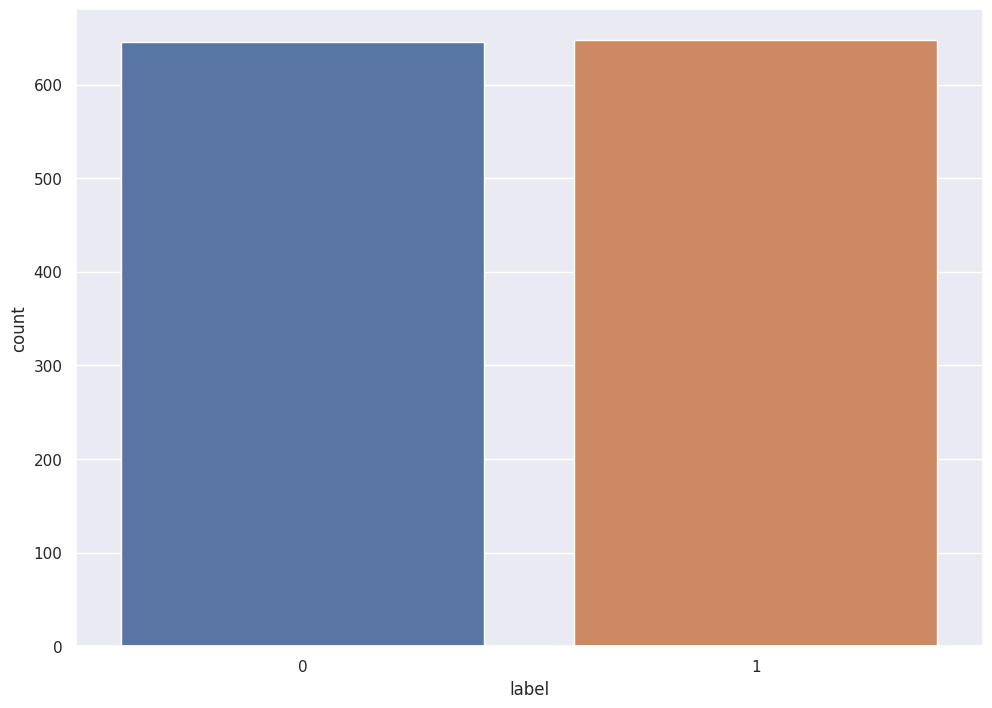

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x=train['label'])
ax.tick_params(axis='x')

In [ ]:
sampled_train = train.sample(frac=1).reset_index(drop=True)
sampled_test = test.sample(frac=1).reset_index(drop=True)

In [ ]:
train_data_loader = create_data_loader(sampled_train, tokenizer)
test_data_loader = create_data_loader(sampled_test, tokenizer, shuffle=False)

In [ ]:
ssu_model = DiscourseClassifier(2)
ssu_model = ssu_model.to(device)

EPOCHS = 10
optimizer = AdamW(ssu_model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
trainer(ssu_model, EPOCHS)

Epoch 1/10
----------
Train loss 0.458987160505336 accuracy 0.8013910355486862
Epoch 2/10
----------
Train loss 0.39624164327059264 accuracy 0.8454404945904173
Epoch 3/10
----------
Train loss 0.34313126908684216 accuracy 0.875579598145286
Epoch 4/10
----------
Train loss 0.25054145195050004 accuracy 0.9142194744976816
Epoch 5/10
----------
Train loss 0.17782774519313266 accuracy 0.9513137557959814
Epoch 6/10
----------
Train loss 0.10222440250907783 accuracy 0.973724884080371
Epoch 7/10
----------
Train loss 0.07596317920143958 accuracy 0.9806800618238022
Epoch 8/10
----------
Train loss 0.03333826225687876 accuracy 0.9922720247295208
Epoch 9/10
----------
Train loss 0.018066971640413005 accuracy 0.9969088098918083
Epoch 10/10
----------
Train loss 0.011251981533994829 accuracy 0.9976816074188563


In [ ]:
y_texts, y_pred, y_pred_probs, y_test = evaluator(ssu_model)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76        97
           1       0.74      0.85      0.79        96

    accuracy                           0.78       193
   macro avg       0.78      0.78      0.78       193
weighted avg       0.78      0.78      0.78       193



# Experiment 2. Scrambled Sentence Detection

In [ ]:
train = scrambled_sentence_preprocessing(WORK_DIR_FOR_TRAIN)
test = scrambled_sentence_preprocessing(WORK_DIR_FOR_TEST, train_mode=False)

In [ ]:
train['text'] = train['text'].apply(lambda x: ' '.join(x))
test['text'] = test['text'].apply(lambda x: ' '.join(x))

In [ ]:
for sent in train['text'][:5]:
    print(sent)

##### Мне лично кажется, как сообщает «РБК-Украина»,
Число протестующих там, что вместо переписывания законов гораздо более действенным было бы надлежащее исполнение существующих. составляет около двух тысяч человек.
##### Женщина обратилась к журналистам светского издания олицетворяемые исламским фундаментализмом и «Аль-Каидой», — она сказала, что больше никто помогать не желает — полиция с гурскими хасидами не связывается.
Здесь переплелись и вызовы арабо-мусульманского мира, от отчаяния и традиционные проблемы Чёрной Африки: диктатура, коррупция, трайбализм и клановость.
##### В то время как внимание всего мира сосредоточено на Ираке, Северной Корее и возможном конфликте с Ираном чтобы это событие было предано забвению Косово сошло с экранов радаров.


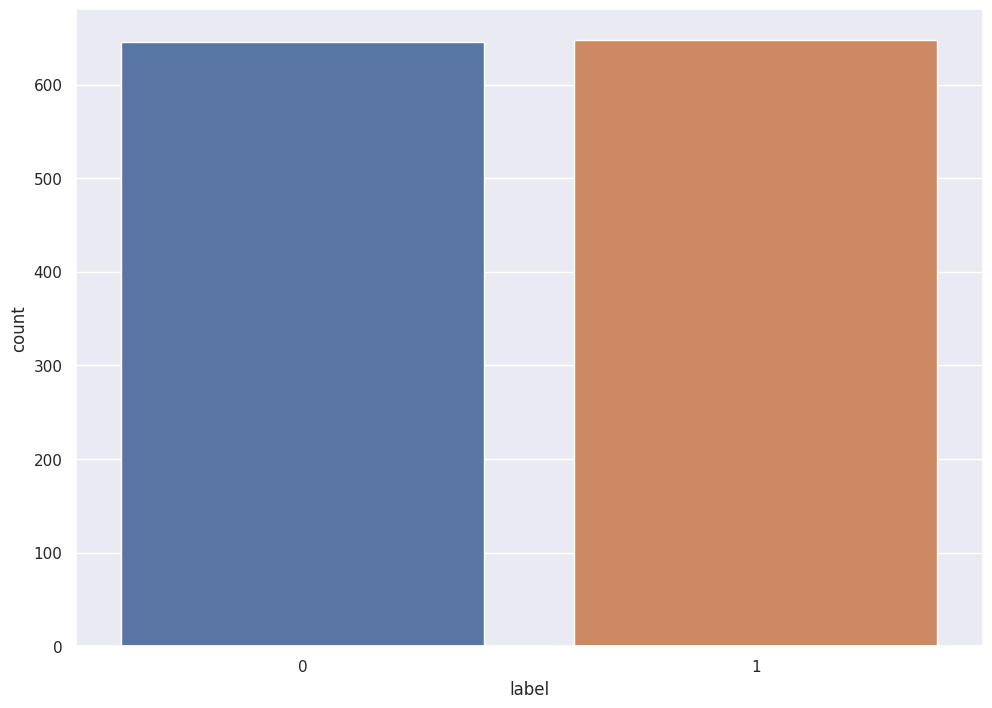

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x=train.label)
ax.tick_params(axis='x')

In [ ]:
sampled_train = train.sample(frac=1).reset_index(drop=True)
sampled_test = test.sample(frac=1).reset_index(drop=True)

In [ ]:
train_data_loader = create_data_loader(sampled_train, tokenizer)
test_data_loader = create_data_loader(sampled_test, tokenizer, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
ssd_model = DiscourseClassifier(2)
ssd_model = ssd_model.to(device)

EPOCHS = 4
optimizer = AdamW(ssd_model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
trainer(ssd_model, EPOCHS)

Epoch 1/4
----------
Train loss 0.5534202263311103 accuracy 0.7272024729520865
Epoch 2/4
----------
Train loss 0.30419889285608576 accuracy 0.8910355486862442
Epoch 3/4
----------
Train loss 0.12452038689401507 accuracy 0.9667697063369397
Epoch 4/4
----------
Train loss 0.04704071098168231 accuracy 0.9891808346213292


In [ ]:
y_texts, y_pred, y_pred_probs, y_test = evaluator(ssd_model)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        98
           1       0.81      0.93      0.86        95

    accuracy                           0.85       193
   macro avg       0.86      0.86      0.85       193
weighted avg       0.86      0.85      0.85       193



#Experiment 3. Relation Semantics Detection

In [ ]:
train = relation_detection_preprocessing(WORK_DIR_FOR_TRAIN)
test = relation_detection_preprocessing(WORK_DIR_FOR_TEST)

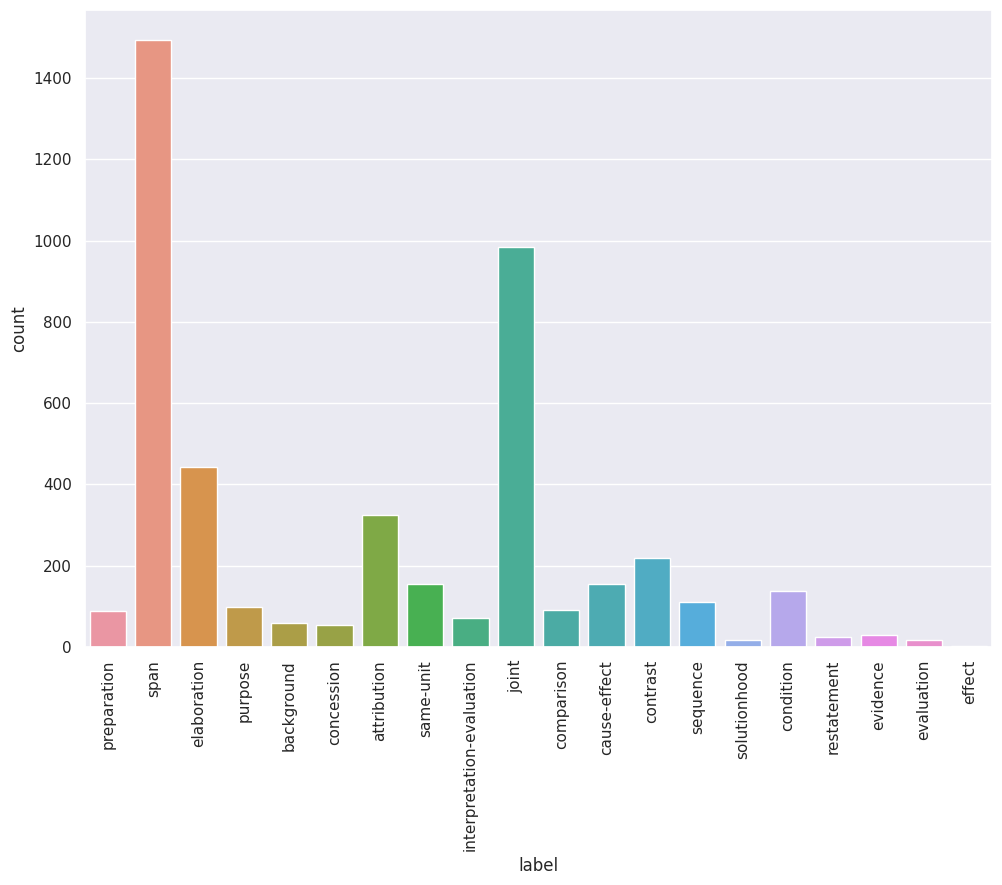

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x=train.label)
ax.tick_params(axis='x', rotation=90)

In [ ]:
train = train.drop(train[train['label']=='span'].index)
train = train.drop(train[train['label']=='evaluation'].index)
train = train.drop(train[train['label']=='effect'].index)

In [ ]:
test = test.drop(test[test['label']=='span'].index)
test = test.drop(test[test['label']=='evaluation'].index)
test = test.drop(test[test['label']=='effect'].index)

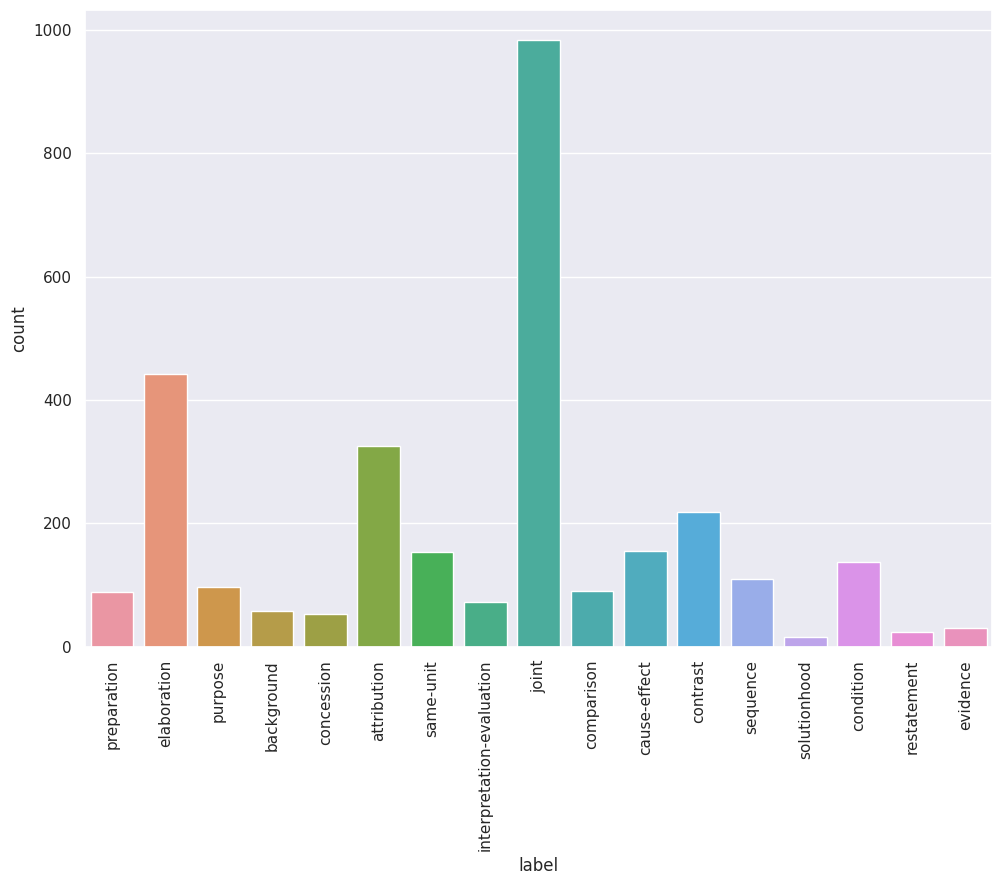

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x=train.label)
ax.tick_params(axis='x', rotation=90)

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(train['label'])
y_test = le.transform(test['label'])
train['class name'] = train['label'].copy()
test['class name'] = test['label'].copy()
train['label'] = y_train
test['label'] = y_test

print(train)

                                                   text  label   class name
0      Недавно Соединенные Штаты добились сомнительн...     11  preparation
2     - на протяжении долгого времени бывшую их един...      7  elaboration
4     чтобы сэкономить на этом деньги. => Они достиг...     12      purpose
5     А несколькими годами раньше, когда Америка бро...      1   background
7     - несмотря на то, что население Китая более че...      4   concession
...                                                 ...    ...          ...
4557  занимавшейся разработкой нефти в Патагонии на ...     14    same-unit
4559  принадлежавших Repsol, => Государство первонач...      7  elaboration
4560  без уплаты каких-либо компенсаций. => Государс...     14    same-unit
4561  В качестве причин в Буэнос-Айресе указали => В...      0  attribution
4564  но она до сих пор не разглашается. => В конечн...      4   concession

[3055 rows x 3 columns]


In [ ]:
sampled_train = train.sample(frac=1).reset_index(drop=True)
sampled_test = test.sample(frac=1).reset_index(drop=True)

In [ ]:
train_data_loader = create_data_loader(sampled_train, tokenizer)
test_data_loader = create_data_loader(sampled_test, tokenizer, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
rsd_model = DiscourseClassifier(17)
rsd_model = rsd_model.to(device)

EPOCHS = 10
optimizer = AdamW(rsd_model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
trainer(rsd_model, EPOCHS)

Epoch 1/10
----------
Train loss 2.116068607225468 accuracy 0.39901800327332243
Epoch 2/10
----------
Train loss 1.3440940841954416 accuracy 0.6301145662847791
Epoch 3/10
----------
Train loss 0.8605325522379101 accuracy 0.7682487725040917
Epoch 4/10
----------
Train loss 0.5277849576236066 accuracy 0.8648117839607202
Epoch 5/10
----------
Train loss 0.30440735097252886 accuracy 0.9260229132569558
Epoch 6/10
----------
Train loss 0.18802521972190492 accuracy 0.9567921440261866
Epoch 7/10
----------
Train loss 0.11601377687665648 accuracy 0.9751227495908348
Epoch 8/10
----------
Train loss 0.07245423930760532 accuracy 0.9852700490998364
Epoch 9/10
----------
Train loss 0.05512223890324303 accuracy 0.9878887070376433
Epoch 10/10
----------
Train loss 0.04511492127913455 accuracy 0.990834697217676


In [ ]:
y_texts, y_pred, y_pred_probs, y_test = evaluator(rsd_model)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        45
           1       0.14      0.10      0.12        10
           2       0.48      0.46      0.47        24
           3       0.00      0.00      0.00         9
           4       0.70      0.70      0.70        10
           5       0.83      0.73      0.77        33
           6       0.54      0.61      0.57        36
           7       0.70      0.75      0.73        69
           8       0.50      0.12      0.20         8
           9       0.25      0.29      0.27         7
          10       0.66      0.70      0.68       136
          11       0.60      0.60      0.60        10
          12       0.74      0.82      0.78        17
          13       0.00      0.00      0.00         3
          14       0.73      0.55      0.63        20
          15       0.33      0.20      0.25        10
          16       0.40      0.67      0.50         3

    accuracy              